### Here we train on fake data using new window design, and prototype some new metrics for analyzing q(Z)

In [1]:
import imagery_psychophysics.src.variational as very
import numpy as np
import pandas as pd
import math
import copy
from matplotlib import pyplot as plt
from os.path import join
from PIL.Image import open as open_image
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_TeZaJ0.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX TITAN X (0000:01:00.0)


### Create the fake data

Set up basic model parameters and objects

In [36]:
##model variable parameters
K = 4
D1,D2 = 16,16
dispersion = 2.2
pon,poff = 0.99, .005

##number of objects
nObj = very.numObjects()
nObj.set_value(K)

##dispersion on category prior
pDisp = very.priorDispersion()
pDisp.set_value(dispersion)

##resolution of object map Z
nPixels = very.numPixels()
nPixels.set_value(D1,D2)

##category prior and object map
catProb = very.categoryProbs(nObj,pDisp)
catProb.set_value(catProb.sample())
Z = very.latentObjMap(catProb,nPixels)
originalZ = copy.deepcopy(Z)


##noise params: we don't set these because we're going to learn them
nP = very.noiseParams()



Construct the experimental probes. This is where we determine the native resolution of the experiment, and the working resolution for our analysis.

In [37]:
##windows
DPrime1,DPrime2 = 8*D1, 8*D2 ##this gives the "native resolution" of the windows
shape = (DPrime1,DPrime2)
baseShape = (8, 8) ##size in pixels of the smallest probes
numScales = 4 ##number of probe sizes between smallest and native resolution
stride = 1 ##how far each probe travels when constructing probes, as a fraction of probe size
numRandProbes = 420 ##number of non-contiguous probes
randProbeOrder = (3, 7) ##non-contig probes will contain this many patches (range of)
windows = very.probes() ##instantiate a windows object
W = windows.make_windows(shape, baseShape, numScales, stride, numRandProbes, randProbeOrder) ##create the windows

##now, we want to downsample the windows to a more manageable "working" resolution.
##to do this, we first calculate all of the downsamples that have integer dimensions and preserve the aspect ratio
##we set workingScale=n to choose the nth smallest resolution as our working resolution. 
##NOTE: THIS DOESN'T REALLY WORK BECAUSE EACH NATIVE RESOLUTIONI NEEDS TO BE CLEANLY DIVISIBLE BY WORKING RESOLUTION.
##FOR THE "UPSAMPLING" OF Z TO WORK. SO, BEST JUST TO WORK WITH NATIVE RESOLUTIONS THAT ARE POWERS OF SOME NUMBER.
##LIKE, SAY, 2.
#resolutions, workingResolution = windows.resolve(shape, workingScale=-1) 

##Given the above, we'll just set the working resolution by hand
workingResolution = (64,64)

##next, we downsample the windows, and set_value
windows.set_value(windows.reshape(W, workingResolution),flatten=True)



In [38]:
print 'model resolution: (%d,%d)' %(D1,D2)
print 'native target resolution: (%d,%d)' %shape
print 'working resolution: (%d,%d)' %workingResolution

model resolution: (16,16)
native target resolution: (128,128)
working resolution: (64,64)


Create a "smooth" but random object map to use as a target image

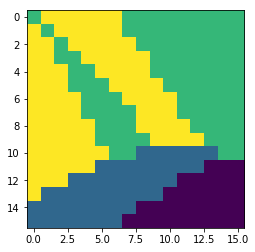

In [39]:
##this gives a 1hot encoding (1, K, D1*D2)
targetZOneHot = very.make_object_map_stack(K, 2, 3, (D1,D2), 1)
_=Z.view_sample(targetZOneHot,show=True)


Simulate responses from our experiment

In [40]:

##response object
r = very.responses(Z,nP)
r.set_values(windows=windows)
data = r.sample(targetZOneHot,pon,poff)
r.set_values(data=data)

print 'total observations: %d' %(r.N)

total observations: 716


(array([  3., 277., 164., 198.,  74.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

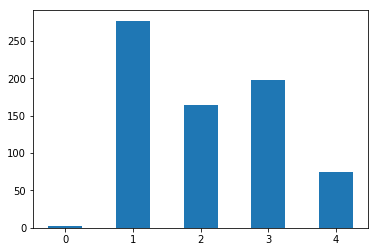

In [41]:
plt.hist(r.observations,bins=range(0,K+2),rwidth = .5, align='left')

### Train the model on the fake responses

In [8]:
pdb on

Automatic pdb calling has been turned ON


In [42]:
##instantiate the variational inferences we want to perform
iqZ = very.inferQZ()
iqPi = very.inferQPi()

##...and the parameter optimizations (point-estimate) we want
oNP = very.optimizeNoiseParams()

##variational inference combines them all together
vi = very.VI(r, iqZ,oNP, iqPi)

### Run variational inference

##inference algorithm parameters
initialNoisinessOfZ = 0.2
pOn_init, pOff_init = .95, 0.05
densityOfNoiseParamGrid = 50
numStarterMaps = 50
numSamplesForComputingObjectCountProbs = 4
maxNumIterations = 30
trainTestSplit = .9
trainRegSplit = .8
pixelNumOverMin = 2
objectNumOverMin = 2

bestModel,_=vi.run_VI(initialNoisinessOfZ, \
                     pOn_init, pOff_init, \
                     densityOfNoiseParamGrid, \
                     numStarterMaps, \
                     numSamplesForComputingObjectCountProbs, \
                     maxNumIterations, \
                     trainTestSplit, trainRegSplit, \
                     optimizeHyperParams=False)

!new best!
ELBO: -493.824768
goodness of fit: -643.850281
posterior_entropy: 150.025497
mean log of predictive distribution over test samples: -0.903199
percent correct over test samples: 64.843750


ELBO: -243.580795
goodness of fit: -405.043060
posterior_entropy: 161.462265
mean log of predictive distribution over test samples: -0.944595
percent correct over test samples: 56.250000


ELBO: -199.198822
goodness of fit: -377.509583
posterior_entropy: 178.310760
mean log of predictive distribution over test samples: -0.953452
percent correct over test samples: 60.937500


ELBO: -185.792099
goodness of fit: -339.214264
posterior_entropy: 153.422165
mean log of predictive distribution over test samples: -0.824708
percent correct over test samples: 64.843750


!new best!
ELBO: -165.110565
goodness of fit: -304.014496
posterior_entropy: 138.903931
mean log of predictive distribution over test samples: -0.802861
percent correct over test samples: 69.531250


!new best!
ELBO: -156.600998
good

In [43]:
vi.bestPercentCorrect

array([77.34375])

In [44]:
bestModel.bestPercentCorrect

array([77.34375])

In [45]:
bestModel.update_current(bestModel.testIdx)


In [46]:
print 'chance percent correct: %f' %(1./K*100)
print 'model percent correct: %f' %(very.percent_correct(bestModel))


chance percent correct: 25.000000
model percent correct: 78.873239


In [14]:
# bestModel.bestNoiseParam

store = pd.io.pytables.HDFStore('/home/tnaselar/NAS/tnaselar/imagery_probe/noisyTrainedExampleModel.h5')

resultsDict = {'trainedModel':bestModel, 'targetZOneHot':[targetZOneHot]}

resultsDf = pd.DataFrame(resultsDict)

store['df'] = resultsDf

store.close()



/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2882: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['targetZOneHot', 'trainedModel']]

  exec(code_obj, self.user_global_ns, self.user_ns)


#### View target and posterior

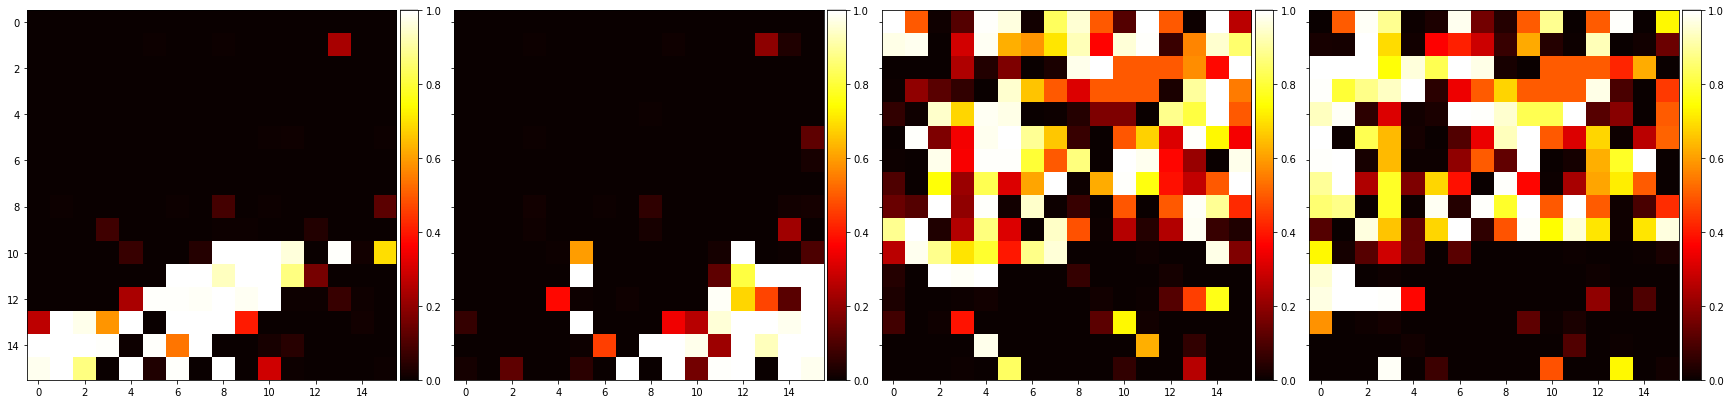

In [47]:
bestModel.see_Q_Z(bestModel.bestQZ)

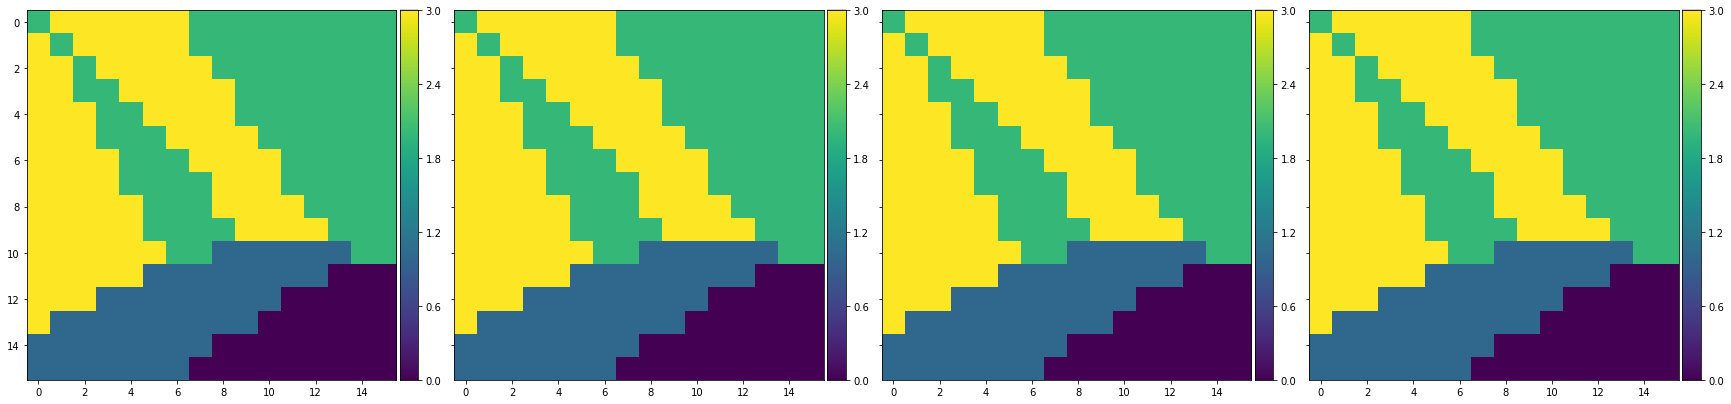

In [48]:
##view the target image, return a canonical (D1, D2) format image
targetZCanonical=Z.view_sample(targetZOneHot,show=False)
fig=plt.figure(3,(30,10))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (1, K), # creates grid of axes
                axes_pad=0.5, # pad between axes in inch.
                cbar_mode = 'each',
                cbar_pad = .05
                )
for kk in range(0,K):
    im = grid[kk].imshow(targetZCanonical,interpolation = 'nearest')
    grid[kk].cax.colorbar(im)    


In [17]:
bestModel.responses.Z.categoryPrior.numObjects.K

array(4, dtype=int32)

#### Pixel entropy maps
Just map the entropy of the posterior at each pixel

In [18]:
def pixel_entropy_map(trainedModel):
    qZ = trainedModel.bestQZ
    shape = (trainedModel.responses.Z.numPixels.D1, trainedModel.responses.Z.numPixels.D2)
    entropyOneHot = np.sum(qZ*np.log(qZ),axis=0)
    entropyCanoncial = entropyOneHot.reshape((shape))
    return entropyOneHot, entropyCanoncial
    

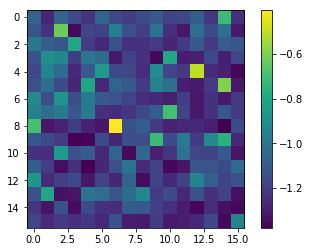

In [19]:
_,entropyCanonical = pixel_entropy_map(bestModel)
plt.imshow(entropyCanonical)
plt.colorbar()

#### compute pixelwise co-membership probability maps (pixelcom map)
For each pixel, map the probability of all other pixels belonging to same object.
Create a stack of such "pixelcom" maps.
Real images will have degenerate (i.e., binary) pixelcom maps

In [20]:
def pixelwise_comembership(trainedModel, alternateQZ= None):
    if alternateQZ is not None:
        qZ = alternateQZ
    else:
        qZ = trainedModel.bestQZ
    D1,D2 = (trainedModel.responses.Z.numPixels.D1, trainedModel.responses.Z.numPixels.D2)
    K = trainedModel.responses.Z.categoryPrior.numObjects.K
    comemMatrix = qZ.T.dot(qZ)
    comemStack = comemMatrix.reshape((D1*D2,D1,D2))
    rows,cols=np.unravel_index(range(D1*D2),(D1,D2))
    coordinateOfEachPixelInStack = np.array([cols,rows]).T
    return comemMatrix, comemStack, coordinateOfEachPixelInStack
    


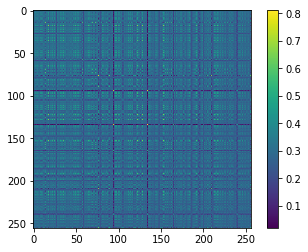

In [21]:
comemMatrix, comemStack, ij = pixelwise_comembership(bestModel)
plt.imshow(comemMatrix)
plt.colorbar()

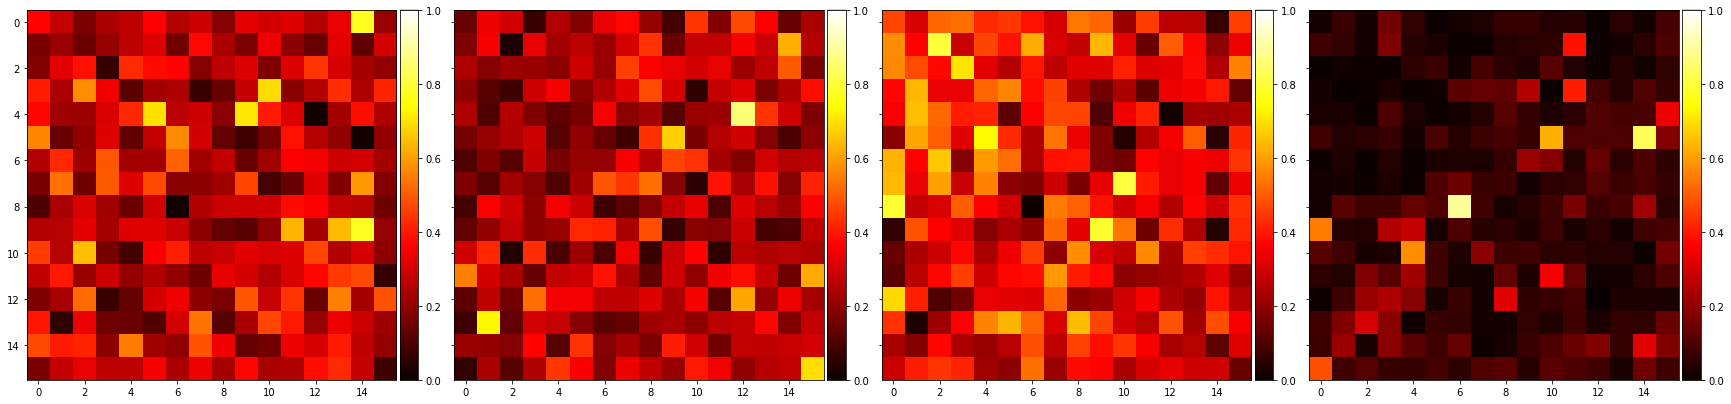

In [22]:
bestModel.see_Q_Z(bestModel.bestQZ)

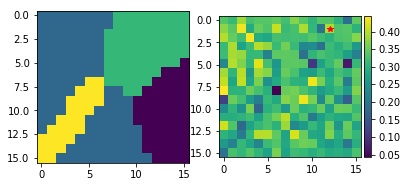

In [23]:
idx = 28
plt.subplot(1,2,1)
plt.imshow(targetZCanonical)
ax =plt.subplot(1,2,2)
im = ax.imshow(comemStack[idx])
ax.plot(ij[idx][0],ij[idx][1], 'r*')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


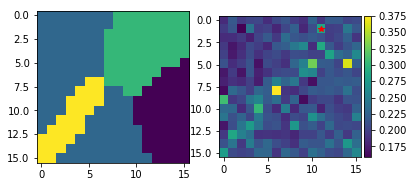

In [24]:
idx = 27
plt.subplot(1,2,1)
plt.imshow(targetZCanonical)
ax =plt.subplot(1,2,2)
im = ax.imshow(comemStack[idx])
ax.plot(ij[idx][0],ij[idx][1], 'r*')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


In [25]:
64**2

4096

#### Calculate the probability of a comembership matrix under qZ

In [26]:
def log_prob_comembership_matrix(trainedModel,objectMap):
    small = 10e-16
    big = 1-small
    expectedComemMatrix,_,_ = pixelwise_comembership(trainedModel)
    ##note: for this to work, alternateQZ must be an object map (i.e., a degenerate qZ)
    objectComemMatrix,_,_ = pixelwise_comembership(trainedModel,alternateQZ=objectMap)
    C = np.clip(expectedComemMatrix.astype('float64'),small,big)
    A = objectComemMatrix.astype('float64')
    logC = np.log(C)
    logOneMinusC = np.log(1-C)
    logProb = np.sum(np.sum(A*logC+(1-A)*logOneMinusC))
    return logProb
    

In [27]:
logProbComem = log_prob_comembership_matrix(bestModel, targetZOneHot[0])
print logProbComem

-39887.873235993386


#### Use comembership matrix to perform image identification
Simply calculate the probability of many random object maps using comemebership matrix

In [28]:
def posterior_image_identification(trainedModel, candidateObjectMapStack):
    ##big nasty loop
    N = candidateObjectMapStack.shape[0]
    measuredComemMatrix = pixelwise_comembership(trainedModel)
    logProbs = np.zeros(N)
    for i,objectMap in enumerate(candidateObjectMapStack):    
        logProbs[i]=log_prob_comembership_matrix(trainedModel, objectMap)
    return logProbs, np.argmax(logProbs)

best Z: 100


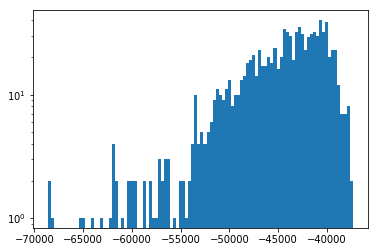

In [29]:
targIdx = 100
lureZ = very.make_object_map_stack(K, 2, 3, (D1,D2), 1000)
lureZ[targIdx] = targetZOneHot[0]
logProbs, bestZ = posterior_image_identification(bestModel, lureZ)
_=plt.hist(logProbs, bins=100, log=True)
print 'best Z: %d' %(targIdx)

#### Calculate the expected value of a comembership matrix
1) generate tons of maps from trained models
2) calculate log_prob_of_comembership_matrix for each sample
3) average.

In [30]:
def expected_log_prob_comembership_matrix(trainedModel, M=100, known=None):
    ##big nasty loop
    expectedComemMatrix = pixelwise_comembership(trainedModel)
    logProbs = np.zeros(M)
    sampleMaps = trainedModel.responses.Z.sample(M=M)
    k
    for i,objectMap in enumerate(sampleMaps):    
        logProbs[i]=log_prob_comembership_matrix(trainedModel, objectMap)
    return logProbs, np.argmax(logProbs)

In [31]:
bestModel.responses.Z.sample

<bound method latentObjMap.sample of <imagery_psychophysics.src.variational.latentObjMap object at 0x7ff24e7ea110>>

In [32]:
from imagery_psychophysics.src.stirling_maps import stirling_num_of_2nd_kind as snk
from imagery_psychophysics.src.stirling_maps import stirling_partitions

#### Some code for generating all possible object maps for a small number of objects/pixels

In [33]:
##but need to sum over all numbers of objects from 1 to K, because these are all on the support of q
num = snk(9,3)
sp = stirling_partitions(range(9),3)

maps = np.zeros((int(num), 3,9))
for ii,obj in enumerate(sp):
    for k in range(3):
        maps[ii][k][obj.pop()]=1


#### compute KL divergence (crossentropy, entropy)

#### ----------------- Tossed ---------------------

In [34]:

# ##==========construct model random variables
# ##number of objects
# nObj = numObjects()

# ##dispersion on category prior: here we set a hyperprior
# pDisp = priorDispersion()
# dispersion = 1.0
# pDisp.set_value(dispersion)

# ##resolution of object map Z
# nPixels = numPixels()

# ##category prior and object map
# catProb = categoryProbs(nObj,pDisp)
# Z = latentObjMap(catProb,nPixels)

# ##noise params
# nP = noiseParams()

# ##windows: we change their shape a little to make them easier to work with
# desiredWindowShape = (375,600)
# workingScale = 5
# w = probes()
# resolutions, workingResolution = w.resolve(desiredWindowShape, workingScale)
# w.set_value(w.reshape(windows, workingResolution),flatten=True)
# print 'working resolution is (%d, %d)' %(workingResolution[0], workingResolution[1])


# ##response object
# r = responses(Z,nP)

# ##fake data
# r.set_values(windows=w)

# r.set_values(data=resp)

# print 'total observations: %d' %(r.N)

# tMap = target_image()
# targetObjectMap_test, targetImage_test = tMap.reshape(targetObjectMap,workingResolution,targetImage=targetImage)
# tMap.set_values(targetObjectMap_test, targetImage_test)
# ##=============

# ##instantiate the variational inferences we want to perform
# iqZ = inferQZ()
# iqPi = inferQPi()

# ##...and the parameter optimizations (point-estimate) we want
# oNP = optimizeNoiseParams()

# ##variational inference combines them all together
# vi = VI(r, iqZ,oNP, iqPi)

# ### Run variational inference

# ##inference algorithm parameters
# initialNoisinessOfZ = 0.2
# pOn_init, pOff_init = .8, 0.2
# densityOfNoiseParamGrid = 50
# numStarterMaps = 20
# numSamplesForComputingObjectCountProbs = 4
# maxNumIterations = 50
# trainTestSplit = 1.0
# trainRegSplit = .8
# pixelNumOverMin = 2
# objectNumOverMin = 2

# print '=========================(subject, state, target) = (%s, %s, %s) ====' %(subject, state, targetImageName)
# bestModel = vi.run_VI(initialNoisinessOfZ, \
#                      pOn_init, pOff_init, \
#                      densityOfNoiseParamGrid, \
#                      numStarterMaps, \
#                      numSamplesForComputingObjectCountProbs, \
#                      maxNumIterations, \
#                      trainTestSplit, trainRegSplit, \
#                      optimizeHyperParams=True, pixelNumOverMin=pixelNumOverMin, objectNumOverMin=objectNumOverMin)

In [35]:
##Create a target image, method 1: Read in an image from a real experiment


# ##a real target from a recent experiment
# ##which repo?
# drive = '/home/tnaselar/FAST/imagery_psychophysics'

# ##base directory
# base = 'multi_poly_probes'

# ##pandas dataframe with all the experimental conditions and data
# data_place = 'data'
# data_file = 'multi_poly_probe_data_3_subjects.pkl'
# subject = 'KL'
# state = 'pcp'


# ##target images
# image_place = 'masks'
# target_image_name = 'candle_01'
# target_image_file = 'candle_mask_mostbjs.tif'

# ##window files
# window_place = 'probes'
# window_file = 'candle_01_letterbox_img__probe_dict.pkl'


# ##open
# test_object_map = open_image(join(drive, base, image_place, target_image_file),mode='r').convert('L')

# ##record K
# values = np.array(np.unique(test_object_map))
# targetK = len(values)

# ##resize to window, checking for preserved K
# test_object_map=test_object_map.resize((test_object_map.size[1], test_object_map.size[0]),)
# values = np.array(np.unique(test_object_map))
# assert targetK==len(values)

# ##digitize, checking 
# test_object_map=np.digitize(test_object_map, bins=values, right=True ).astype(int)
# values = np.array(np.unique(test_object_map))
# assert targetK==len(values)

# ##one-hot encoding
# fullscreenSize = np.prod(test_object_map.size)
# test_object_map = np.eye(K)[test_object_map.ravel()].T.reshape((1,targetK,fullscreenSize))

# ##view
# test_object_map_image = see_Z_sample(test_object_map[0], window_shape, show=False)
# plt.imshow(test_object_map_image, cmap='Dark2')
# plt.imshow(W[-5].reshape(window_shape).astype('uint8')*255, interpolation='none', alpha = .2, cmap=plt.cm.gray, clim=[0,255])